In [2]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from scipy.sparse import hstack, csr_matrix
import joblib

df   = pd.read_csv('techno.csv')
df2  = pd.read_csv('messages_features_big.csv')
df3  = pd.read_csv('spam_test.csv')
df4  = pd.read_csv('clean_test.csv')

df2['target'] = 1
df3['target'] = 1
df4['target'] = 0

df2['char_length'] = df2['char_length'] / df2['word_count']

df_train = pd.concat([ df, df2 ], ignore_index=True)
df_test  = pd.concat([ df3, df4 ], ignore_index=True)

for D in (df_train, df_test):
    D.dropna(subset=['text'], inplace=True)
    D = D[D['text'].str.strip()!='']

feat_cols = [c for c in df_train.columns if c not in ('text','target')]

vec    = TfidfVectorizer(max_features=10000)
X_text = vec.fit_transform(df_train['text'])
X3_text = vec.transform(df_test['text'])

X_feats    = df_train[feat_cols].fillna(0).astype(float).values
X3_feats   = df_test[feat_cols].fillna(0).astype(float).values

X_feats    = csr_matrix(X_feats)
X3_feats   = csr_matrix(X3_feats)

X_train = hstack([X_text,  X_feats])
X_test  = hstack([X3_text, X3_feats])

y_train = df_train['target'].values
y_test  = df_test['target'].values

model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Classification report:\n", classification_report(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

joblib.dump({'model': model, 'vectorizer': vec}, 'l_model_with_all_feats.pkl')


Classification report:
               precision    recall  f1-score   support

           0       0.44      0.99      0.61     23401
           1       0.99      0.48      0.64     56164

    accuracy                           0.63     79565
   macro avg       0.72      0.73      0.63     79565
weighted avg       0.83      0.63      0.63     79565

Confusion matrix:
 [[23248   153]
 [29455 26709]]


['l_model_with_all_feats.pkl']

=== Отчёт при threshold = 0.3 ===
              precision    recall  f1-score   support

           0       0.50      0.99      0.67     23401
           1       0.99      0.59      0.74     56164

    accuracy                           0.71     79565
   macro avg       0.75      0.79      0.70     79565
weighted avg       0.85      0.71      0.72     79565

Confusion matrix:
[[23120   281]
 [22964 33200]]


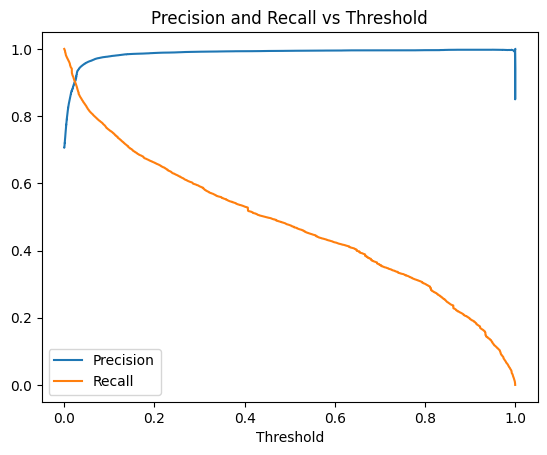

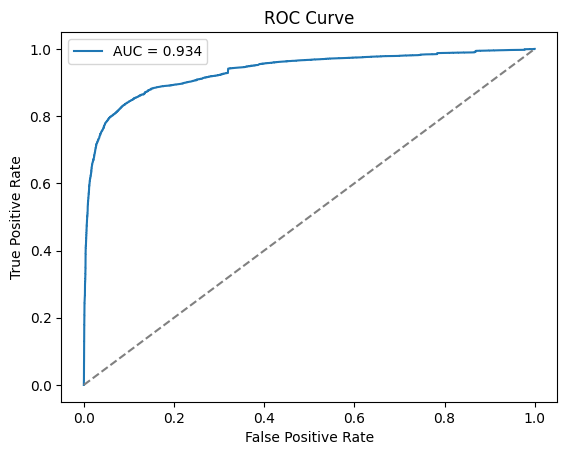

In [36]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt

y_proba = model.predict_proba(X_test)[:, 1]

threshold = 0.3  # например, 30%

y_pred_thresh = (y_proba >= threshold).astype(int)

print(f"=== Отчёт при threshold = {threshold} ===")
print(classification_report(y_test, y_pred_thresh))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred_thresh))


precision, recall, pr_thresholds = precision_recall_curve(y_test, y_proba)
plt.figure()
plt.plot(pr_thresholds, precision[:-1], label='Precision')
plt.plot(pr_thresholds, recall  [:-1], label='Recall')
plt.xlabel('Threshold')
plt.legend()
plt.title('Precision and Recall vs Threshold')
plt.show()


fpr, tpr, roc_thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()
